## NLP Assignment

In [1]:
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from keras.models import Sequential,Model
from keras.layers import Input,Dense,Dropout,Activation
from keras.utils import np_utils
from sklearn.preprocessing import  LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf

Using TensorFlow backend.


### Extract 20_newsgroup in the notebook directory

In [46]:
base_path=os.getcwd() + '/nlp_training/' 
base_path=os.path.join(base_path,'20_newsgroups')
news_dirs=os.listdir('nlp_training/20_newsgroups')

In [47]:
input_emails = []
output_labels = []
file_path=[]
for _dir in news_dirs:
    for _file in os.listdir(os.path.join(base_path, _dir)):
        output_labels.append(_dir)
        file_path.append(os.path.join(_dir,_file))
        with open(os.path.join(os.path.join(base_path,_dir), _file)) as f:
            input_emails.append(f.read())

dataset_df = pd.DataFrame({'emails': input_emails, 'labels': output_labels,'file_path':file_path })

,emails,file_path,labels
0,Xref: cantaloupe.srv.cs.cmu.edu talk.politics....,talk.politics.guns/54506,talk.politics.guns
1,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,talk.politics.guns/55235,talk.politics.guns
2,Xref: cantaloupe.srv.cs.cmu.edu talk.politics....,talk.politics.guns/54398,talk.politics.guns
3,Newsgroups: talk.politics.guns\nPath: cantalou...,talk.politics.guns/54527,talk.politics.guns
4,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,talk.politics.guns/54749,talk.politics.guns


In [4]:
test_email = dataset_df[dataset_df['file_path']== 'talk.politics.guns/53293']['emails']

In [13]:
def remove_redundancy_words(test_email):
    
    x=re.sub(r'(Xref|Newsgroups|Path|From|Organization|Distribution|Message|Date|Message-ID|Followup-To|\
          |X-Newsreader|References|Rate|Lines|Sender|NNTP-Posting-Host|Nntp-Posting-Host|Reply-To|Keywords):.*','',test_email)
    return re.sub(r'[^a-zA-Z ]',' ',x)

def remove_redundancy_sent(test_email):
    
    x = re.sub(r'(Xref|Newsgroups|Path|From|Organization|Distribution|Message|Date|Message-ID|Followup-To|\
          |X-Newsreader|References|Rate|Lines|Sender|NNTP-Posting-Host|Nntp-Posting-Host|Reply-To|Keywords):.*','',test_email)
    return re.sub(r'[^a-zA-Z.!?]',' ', x)

def filter_words(noheader_email):
    count=0
    word_list=word_tokenize(noheader_email)
    filtered_words = [word for word in word_list if word not in stopwords.words('english') and len(word) >2]
    return filtered_words

def filter_sent(noheader_email):
    filtered_sents=sent_tokenize(noheader_email.encode('ascii', 'ignore'))
    return filtered_sents

def word_indicator(words, **kwargs):
    features = []
    for w in words:
        features[w]=True
    return features

In [14]:
dataset_df['noheaders_emails'] = dataset_df['emails'].map(remove_redundancy_words)

In [15]:
dataset_df['filtered_words'] = dataset_df['noheaders_emails'].map(filter_words)

In [16]:
dataset_df['noheaders_emails2']=dataset_df['emails'].map(remove_redundancy_sent)

In [17]:
dataset_df['filtered_sent'] = dataset_df['noheaders_emails2'].map(filter_sent)

In [18]:
dataset_df['serialized_words']=dataset_df['filtered_words'].map(lambda x: ' '.join(x))
corpus=dataset_df['serialized_words'].tolist()

### Save the data to csv file

In [19]:
dataset_df.to_csv("nlp_training/out.csv")

### Checkpoint

In [2]:
if os.path.isfile("nlp_training/out.csv"):
    dataset_df=pd.read_csv("nlp_training/out.csv")

In [3]:
corpus=dataset_df['serialized_words'].tolist()

In [4]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectorizer.fit(corpus)
X_tfidf_vect = tfidf_vectorizer.transform(corpus)

In [5]:
encoder = LabelEncoder()
y_onehot = encoder.fit_transform(dataset_df['labels'].tolist())

In [6]:
tfidf_vectorizer.get_feature_names()
df_examine=pd.DataFrame({'Features':tfidf_vectorizer.get_feature_names(),'importance':X_tfidf_vect})

In [107]:
x_train, x_test, y_train, y_test = train_test_split(X_tfidf_vect,y_onehot, test_size = 0.2)

print len(y_train)
print len(y_test)

15997
4000


In [8]:
clf = MultinomialNB().fit(x_train, y_train)

In [9]:
features = df_examine['Features']
ouput_labels = dataset_df['labels']

### Test something

In [10]:
# docs_new = ['have faith in God', 'GTX 1080 GPU is powerful']
# # X_new_counts = count_vect.transform(docs_new)
# # X_new_tfidf = tfidf_transformer.transform(X_new_counts)
# X_train_tfidf = tfidf_vectorizer.fit_transform(docs_new)
# print tfidf_vectorizer.get_feature_names()
# print X_train_tfidf
# predicted = clf.predict(X_train_tfidf)

# for doc, category in zip(docs_new, predicted):
#     print('%r => %s' % (doc, category))

In [11]:
docs = x_test
predicted = clf.predict(x_test)
accuracy_score(predicted,y_test)


0.83474999999999999

In [12]:
clf = svm.LinearSVC()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
accuracy_score(pred, y_test)

0.86075000000000002

In [14]:
def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        #print(cm)
        
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

### Visualize confusion matrix

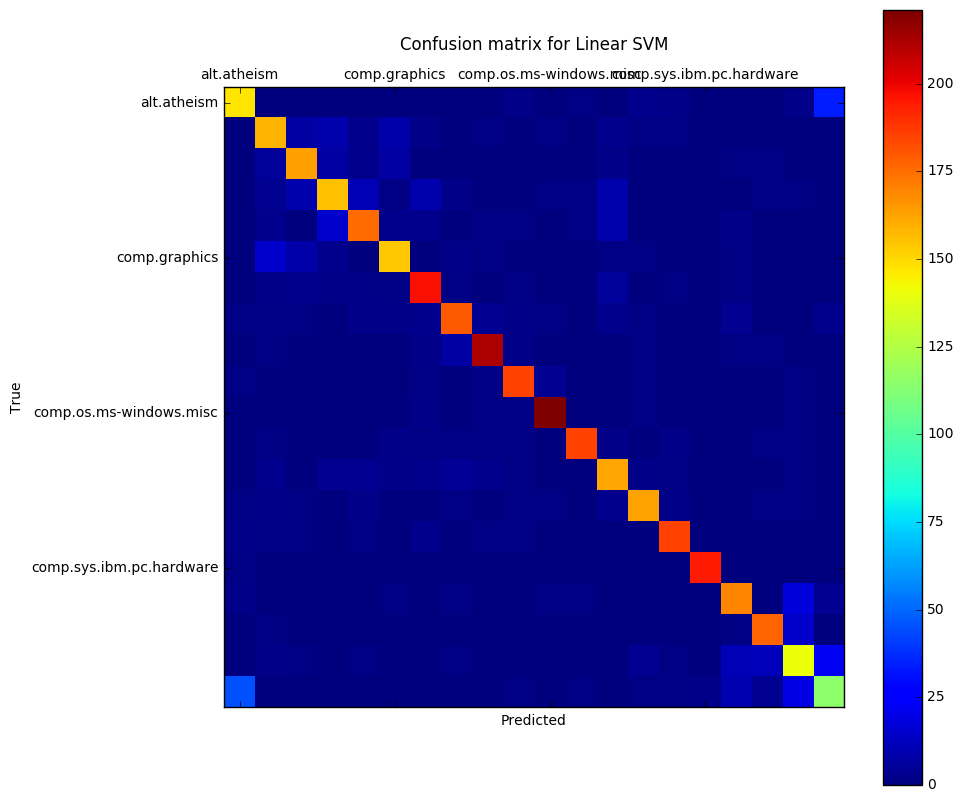

In [15]:

class_names = np.unique(np.array(dataset_df['labels']))
confusion_matrices = [
    ( "Linear SVM", confusion_matrix(y_test, pred)),
    ]
draw_confusion_matrices(confusion_matrices,class_names)

In [108]:
x_Train, x_val, y_Train, y_val = train_test_split(x_train,y_train, test_size = 0.1)

In [137]:
def batch_generator(X, y, batch_size,samples_per_epoch):
    number_of_batches = (samples_per_epoch)/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter < number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [164]:
model = Sequential()
model.add(Dense(1024,input_dim=5000, init='normal', activation='relu'))
model.add(Dropout(.2))
model.add(Dense(512, init='normal', activation='relu'))
model.add(Dropout(.2))
model.add(Dense(256, init='normal', activation='relu'))
model.add(Dropout(.2))
model.add(Dense(128, init='normal', activation='relu'))
model.add(Dropout(.2))
model.add(Dense(20, init='normal', activation='softmax'))
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [165]:
#model.fit(x_train.toarray(),y_train,nb_epoch=10,batch_size=32)

In [171]:
model.fit_generator(generator=batch_generator(x_Train, y_Train, 128,x_Train.shape[0]),
                    nb_epoch=25, samples_per_epoch=x_Train.shape[0],
                    validation_data=batch_generator(x_val, y_val, 128,x_val.shape[0]), nb_val_samples=x_val.shape[0])

Epoch 1/25
12800/12797 [==============================] - 16s - loss: 0.0546 - acc: 0.9773 - val_loss: 0.8785 - val_acc: 0.8191
Epoch 2/25
12800/12797 [==============================] - 15s - loss: 0.0576 - acc: 0.9773 - val_loss: 0.8918 - val_acc: 0.8144
Epoch 3/25
12800/12797 [==============================] - 17s - loss: 0.0569 - acc: 0.9756 - val_loss: 0.8483 - val_acc: 0.8297
Epoch 4/25
12800/12797 [==============================] - 14s - loss: 0.0490 - acc: 0.9783 - val_loss: 1.0411 - val_acc: 0.8056
Epoch 5/25
12800/12797 [==============================] - 15s - loss: 0.0468 - acc: 0.9787 - val_loss: 0.9760 - val_acc: 0.8128
Epoch 6/25
12800/12797 [==============================] - 15s - loss: 0.0487 - acc: 0.9777 - val_loss: 0.9892 - val_acc: 0.8191
Epoch 7/25
12800/12797 [==============================] - 15s - loss: 0.0434 - acc: 0.9799 - val_loss: 0.9852 - val_acc: 0.8219
Epoch 8/25
12800/12797 [==============================] - 14s - loss: 0.0438 - acc: 0.9784 - val_loss: 1

In [170]:
loss_and_metrics = model.evaluate(x_test.toarray(), y_test, batch_size=32)
print loss_and_metrics

3872/4000 [============================>.] - ETA: 0s[0.83912400352954863, 0.81850000000000001]


In [168]:
pred=model.predict_classes(x_test.toarray())

3904/4000 [============================>.] - ETA: 0s

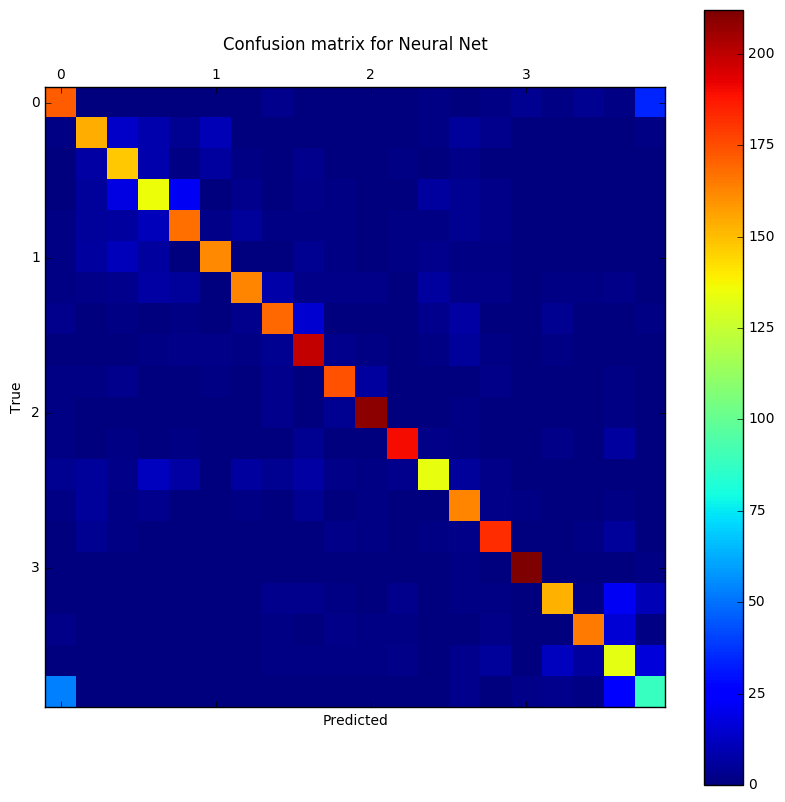

In [169]:
class_names = np.unique(np.array(y_test))
confusion_matrices = [
    ( "Neural Net", confusion_matrix(y_test, pred)),
    ]
draw_confusion_matrices(confusion_matrices,class_names)

15997

In [233]:
y_val

array([ 7,  3,  3, ..., 19, 17,  2])